In [2]:
!pip install torch==0.4.0 torchvision pillow==5.1.0
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!wget -O google_test_data.zip "https://www.dropbox.com/s/3zmf1kq58o909rq/google_test_data.zip?dl=1"
!unzip -qq google_test_data.zip -d ./google_data
!unzip -qq flower_data.zip

  Could not find a version that satisfies the requirement torch==0.4.0 (from versions: 0.1.2, 0.1.2.post1)
No matching distribution found for torch==0.4.0
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import numpy as np, torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import PIL

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

#this is a fix to ignore import errors #copy pasted from StackOverflow..
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:

train_transforms = transforms.Compose([transforms.RandomRotation(18),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
trainset=torchvision.datasets.ImageFolder('flower_data/train/', transform=train_transforms)

In [7]:
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
testset=torchvision.datasets.ImageFolder('flower_data/valid/', transform=test_transforms)


In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader= torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [9]:
model=models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\rohit/.torch\models\resnet152-b121ed2d.pth
100%|███████████████████████████████████████████████████████████████| 241530880/241530880 [00:51<00:00, 4680047.22it/s]


In [10]:
for param in model.parameters():
    param.requires_grad = False
    
from torch import nn
    
model.fc = nn.Sequential(nn.Linear(2048,1100),
                                 nn.BatchNorm1d(1100),
                                 nn.ReLU(),
                                 nn.Linear(1100,512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Linear(512,102),
                                 nn.LogSoftmax(dim=1)
                                )

In [11]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [13]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()

CUDA is available!  Training on GPU ...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [14]:

epochs = 2
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for images, labels in trainloader:
      if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        images.shape
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else :   
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                  if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    logps = model(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            model.train()        
            print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
    

Epoch 1/2.. Train loss: 143.094.. Test loss: 2.412.. Test accuracy: 0.635
Epoch 2/2.. Train loss: 96.670.. Test loss: 1.659.. Test accuracy: 0.788


In [15]:
import os

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    im = im.resize((256,256))
    value = 0.5*(256-224)
    im = im.crop((value,value,256-value,256-value))
    im = np.array(im)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = (im - mean) / std

    return im.transpose(2,0,1)

In [17]:
c

NameError: name 'c' is not defined

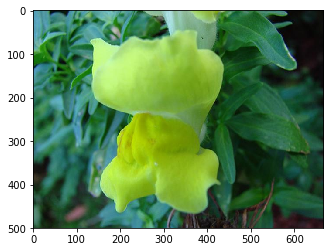

In [18]:
img_path = 'flower_data/train/11/image_03095.jpg'

with Image.open(img_path) as image:
    plt.imshow(image)

In [19]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # move the model to cuda
    cuda = torch.cuda.is_available()
    if cuda:
        # Move model parameters to the GPU
        model.cuda()
        print("Number of GPUs:", torch.cuda.device_count())
        print("Device name:", torch.cuda.get_device_name(torch.cuda.device_count()-1))
    else:
        model.cpu()
        print("We go for CPU")
    
    # turn off dropout
    model.eval()

    # The image
    image = process_image(image_path)
    
    # tranfer to tensor
    image = torch.from_numpy(np.array([image])).float()
    
    # The image becomes the input
    image = Variable(image)
    if cuda:
        image = image.cuda()
        
    output = model.forward(image)
    
    probabilities = torch.exp(output).data
    
    # getting the topk (=5) probabilites and indexes
    # 0 -> probabilities
    # 1 -> index
    prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
    index = torch.topk(probabilities, topk)[1].tolist()[0] # index
    
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    # transfer index to label
    label = []
    for i in range(5):
        label.append(ind[index[i]])

    return prob, label

In [20]:
from torch.autograd import Variable

In [21]:
model.class_to_idx = trainset.class_to_idx

Number of GPUs: 1
Device name: GeForce GTX 1050 Ti
[0.051333650946617126, 0.04130186140537262, 0.0202466007322073, 0.019934331998229027, 0.019683778285980225]
['22', '47', '37', '31', '70']
['pincushion flower', 'marigold', 'cape flower', 'carnation', 'tree poppy']


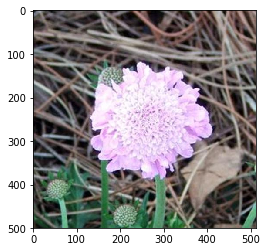

In [22]:
img_path = 'flower_data/train/22/image_05340.jpg'

with Image.open(img_path) as image:
    plt.imshow(image)
prob, classes = predict(img_path, model)
print(prob)
print(classes)
print([cat_to_name[x] for x in classes])    
    
    

Number of GPUs: 1
Device name: GeForce GTX 1050 Ti


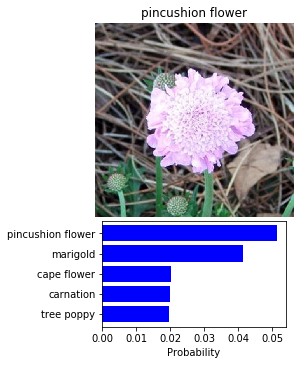

In [23]:
prob, classes = predict(img_path, model)
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(img_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)

labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

plt.show()

In [31]:

torch.save(model.state_dict(), 'checkpoint.pt')